In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import progressbar
import types

from json_data_getter import get_all_json

# Data preparation

## Loading

In [2]:
# gets all the json files toghether, may take a minute
number_documents, keys, documents = get_all_json()
df = pd.DataFrame.from_dict(documents)

100% (109 of 109) |#######################| Elapsed Time: 0:00:36 Time: 0:00:36


## Cleaning

In [3]:
# keep NaN for float columns, empty strings for string columns
for col in df:
    # get dtype for column
    dt = df[col].dtype
    # check if it is a number
    if dt == int or dt == float:
        pass
    else:
        df[col].fillna("", inplace=True)

# set dates to datetime type
df['publicationDate'] = pd.to_datetime(
    df['publicationDate'], format='%Y-%m-%dT%H:%M:%SZ')

In [4]:
# some columns contain list of strings and strings, so we change list of string to sentences
# furthermore, some words are not separated by commas, we do a littre workaround to add commas if they don't exist
def stringlist_to_string(s):
    temp = ''
    if isinstance(s, str):
        if ',' not in s:
            temp = s.replace(' ', ', ')
        else:
            temp = s
    else:
        temp = ', '.join(s)

    # and lowercase because some of theme are uppercases only
    return temp.lower()


for t in [
        'genres', 'thematicCorporations', 'thematicGeographicals',
        'thematicPersons', 'thematicThemes', 'visualCorporations',
        'visualGeographicals', 'visualPersons', 'visualThemes'
]:
    df[t] = df[t].apply(stringlist_to_string)

## distribution in time

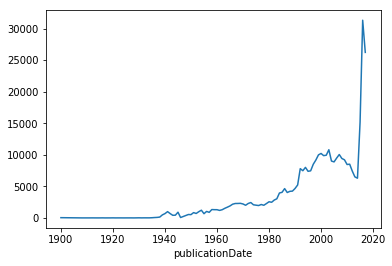

In [5]:
doc_per_year = df.groupby(df.publicationDate.map(lambda x: x.year)).size()
doc_per_year.plot()
plt.show()

We have a lot more data since the ~90's, and way more of the couple of last years. This mean that our event analysis would make more sense on recent event

## Programs lifespan

In [6]:
def get_program_lifespan(df):
    program_groups = df.groupby(df.program)
    df_lifespan = program_groups.publicationDate.agg(['min', 'max', 'size'])
    df_lifespan['lifespan_days'] = (
        df_lifespan['max'] - df_lifespan['min']).astype('timedelta64[D]')
    return df_lifespan

In [7]:
get_program_lifespan(df).sort_values('lifespan_days', ascending=False).head()

,min,max,size,lifespan_days
program,,,,
,1900-01-01 00:00:00,2017-11-15 00:00:00,20458,43052.0
TJ midi,1900-01-01 19:00:00,2011-12-04 11:45:00,204,40878.0
Marabout de ficelle,1900-01-01 00:00:00,1998-05-20 00:00:00,148,35933.0
Mémoires de la musique,1922-06-05 00:00:00,2004-01-23 00:00:00,2086,29817.0
Archives,1939-11-30 02:00:00,2017-10-03 13:10:37,120,28432.0


The first row is the group of unnamed programs. Some duration seem a bit too long, maybe there are errors in the dates. Let's take TJ midi and check the distribution of transmissions by year.

In [8]:
def plot_program_lifespan(program, df):
    program_groups = df.groupby(df.program)
    group = program_groups.get_group(program)
    date_distribution = group.groupby(
        group.publicationDate.map(lambda x: (x.year))).size()
    plt.bar(date_distribution.index, date_distribution.values)
    plt.show()

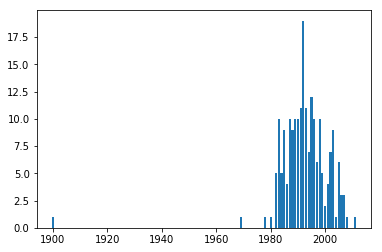

In [9]:
plot_program_lifespan('TJ midi', df)

There are some obvious outliers, let's remove them.

### Date outliers removal

Here we replace the dates with NaT if the year is to far from the mean year of a program.

In [10]:
# remove date outliers
def remove_date_outliers(df):
    CONSTANT_STD = 2
    df_without_date_outliers = df.copy()

    df['publicationDateYear'] = df.publicationDate.map(lambda x: x.year)

    mean_std_year_per_program = df.groupby(df.program).publicationDateYear.agg(
        ["mean", 'std'])

    temp_df = pd.merge(
        df,
        mean_std_year_per_program,
        how='left',
        left_on=['program'],
        right_index=True)

    df_without_date_outliers.loc[
        (np.abs(temp_df.publicationDateYear - temp_df['mean']) >
         CONSTANT_STD * temp_df['std']), 'publicationDate'] = pd.NaT

    return df_without_date_outliers

In [11]:
df_without_date_outliers = remove_date_outliers(df)
get_program_lifespan(df_without_date_outliers).sort_values(
    'lifespan_days', ascending=False).head()

,min,max,size,lifespan_days
program,,,,
,1921-11-23,2017-11-15 00:00:00,20458,35056.0
Documentaire,1952-11-30,2017-11-11 14:00:00,740,23722.0
Cyclisme,1953-11-30,2017-08-19 00:00:00,138,23273.0
Motocyclisme,1954-06-09,2017-08-13 00:00:00,14,23076.0
Souvenirs de vedette,1949-03-31,2009-12-17 00:00:00,4,22176.0


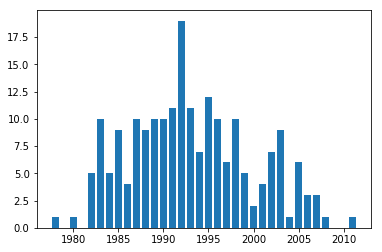

In [12]:
plot_program_lifespan('TJ midi', df_without_date_outliers)

We can see that the distribution seems more natural now.

# Factors for program lifespan

## Themes per period

The goal of this part is to build a tool to get the top occurencies of word in the following categories:
['genres', 'publicationChannelNames', 'thematicCorporations','thematicGeographicals','thematicPersons',
'thematicThemes', 'visualCorporations', 'visualGeographicals', 'visualPersons', 'thematicGeographicals',
'thematicThemes','visualThemes']

We also need to be able to filter by year and by program. This is achieved in the file "word_counter.py". The useful function is "word_counter.get_topn_themes" that takes in argument the starting year and ending year, the type of theme (listed above), a list of programs(TODO), and the number of top occurencies.

In [15]:
import word_counter
WC = word_counter.word_counter(df_without_date_outliers)

In [22]:
test = WC.get_df()[90:100]

In [33]:
from collections import Counter
#test.apply(lambda x : Counter([word.strip() for word in x.split(',') if word not in [' ', '']]))

coucou = test.apply(lambda x : Counter([word.strip() for column in x for word in column.split(',') if word not in [' ', '']]))

In [44]:
coucou = test.applymap(lambda x : Counter([word.strip() for word in x.split(',') if word not in [' ','']]))

In [116]:
counters_program_period = df[[
    'genres', 'thematicCorporations', 'thematicGeographicals',
    'thematicPersons', 'thematicThemes', 'visualCorporations',
    'visualGeographicals', 'visualPersons', 'visualThemes'
]].applymap(lambda x : (Counter([word.strip() for word in x.split(',') if word not in [' ', '']]))).groupby([
    #df.program,
    df.publicationDate.apply(lambda x: x.year)
]).sum()

In [120]:
counters_program_period.applymap(lambda x : dict(x.most_common())).to_json('themes_by_year.json', force_ascii=False)

In [218]:
# this is an example of the top 8 "thematicThemes" of "Temps présent" between 1990 and 2000
WC.get_topn_themes(1990,2000,'thematicThemes', 'Temps présent',n_top=8)

,top1,top2,top3,top4,top5,top6,top7,top8
1990,manifestation politique,cérémonie religieuse,armée,logement,entreprise,scène de rue,conflit armé,écologisme
1991,manifestation politique,armée,enfant (âge),cérémonie religieuse,agriculteur,nationalisme,conflit armé,économie capitaliste
1992,racisme,chômage,armée,économie,politique,enfant (âge),prison,immigration
1993,chômage,bébé,économie capitaliste,économie,adolescence,banane,juifs,nazisme
1994,crise économique,adolescence,économie,vieillesse,quartier,banlieue,suicide,homicide
1995,travail des femmes,vieillesse,de,monarchie,noblesse,vedettariat,bal,presse à sensation
1996,juifs,pauvreté,armée,travail de nuit,travail des femmes,syndicat,condition de travail,années
1997,juifs,antisémitisme,pauvreté,quart-monde,armée,banque,guerre mondiale (deuxième),téléphone
1998,retraite (état),vie sociale,amérindiens,nomadisme,vieillesse,refoulement des étrangers,requérant d'asile,fécondation artificielle
1999,ville,candidate,aux,jeux,olympiques,olympisme,accident aérien,md11


In [219]:
# this is an example of the top 5 "thematicThemes" of all programs between 1935 and 1950
WC.get_topn_themes(1935, 1950, 'thematicThemes',n_top=5)

,top1,top2,top3,top4,top5
1935,paix,conflit armé,relations internationales,vie politique,économie
1936,cirque,roi,guerre mondiale (première),politique,vie politique
1937,relations internationales,cirque,radio,(compétition),politique
1938,guerre mondiale (deuxième),radio,mobilisation générale (1939-1945),armée,histoire
1939,guerre mondiale (deuxième),littérature,mobilisation générale (1939-1945),armée,patriotisme
1940,guerre mondiale (deuxième),patriotisme,littérature,commémoration,écrivain
1941,guerre mondiale (deuxième),patriotisme,rationnement,commémoration,art dramatique
1942,guerre mondiale (deuxième),recette culinaire,rationnement,armée,soldat
1943,guerre mondiale (deuxième),armée,rationnement,recette culinaire,économie de guerre
1944,guerre mondiale (deuxième),résistance (1939-1945),paix,reddition militaire,radio


#### TODO find a nice and dynamic for this tables

## Lifespan category

Now that we have the lifespan of each program, let's see the histogram.

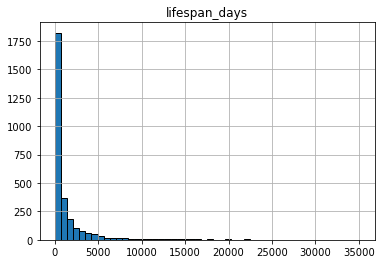

In [26]:
lifespan = get_program_lifespan(df_without_date_outliers)
lifespan.hist(column='lifespan_days', bins=50, ec='black')
plt.show()

The distribution is heavy tailed, lot of programs are really short. Next step is to see how the type of program and the themes are correlated with the lifespan. To do this, we decide to class program in 5 categories of lifespan, each category having the same number of programs.

In [33]:
lifespan['lifespan_class'] = (pd.qcut(
    lifespan.lifespan_days, 5, labels=['very short', 'short', 'medium', 'long', 'very long']))

#### TODO, look at the different themes for each bucket

# dev

In [229]:
j = df_without_date_outliers[100000:100100].to_json()

In [230]:
j

'{"alternativeExcerpt":{"100000":"","100001":"","100002":"","100003":"","100004":"","100005":"","100006":"","100007":"","100008":"","100009":"","100010":"","100011":"","100012":"","100013":"","100014":"","100015":"","100016":"","100017":"","100018":"","100019":"","100020":"","100021":"","100022":"","100023":"","100024":"","100025":"","100026":"","100027":"","100028":"","100029":"","100030":"","100031":"","100032":"","100033":"","100034":"","100035":"","100036":"","100037":"","100038":"","100039":"","100040":"","100041":"","100042":"","100043":"","100044":"","100045":"","100046":"","100047":"","100048":"","100049":"","100050":"","100051":"","100052":"","100053":"","100054":"","100055":"","100056":"","100057":"","100058":"","100059":"","100060":"","100061":"","100062":"","100063":"","100064":"","100065":"","100066":"","100067":"","100068":"","100069":"","100070":"","100071":"","100072":"","100073":"","100074":"","100075":"","100076":"","100077":"","100078":"","100079":"","100080":"","100